In [53]:
from open_quant_data.dataset.thirdparty.akshare.AkshareDataset import AkshareDataset

from datetime import date

import pandas as pd

dataset = AkshareDataset()

high_code = 'sz127022'
low_code = 'sz127067'

dataset_high = dataset.bond_date(high_code, '', '')
dataset_low = dataset.bond_date(low_code, '', '')

dataset_high = dataset_high[dataset_high['date'] >= date(2022, 11, 1)]
dataset_low = dataset_low[dataset_low['date'] >= date(2022, 11, 1)]
dataset_total = pd.DataFrame({
    'price_1': dataset_high['close'].tolist(),
    'price_2': dataset_low['close'].tolist()
})

corr = dataset_total['price_1'].corr(dataset_total['price_2'])

print(corr)

0.9703613387346033


In [54]:
bond_info = pd.read_csv('bond-info.csv')
groups = bond_info.groupby('stock_id').filter(lambda x: len(x) > 1)
result = groups.groupby('stock_id')['bond_id'].apply(list)
print(result)

stock_id
000703.SZ    [127067.SZ, 127022.SZ]
000876.SZ    [127049.SZ, 127015.SZ]
300057.SZ    [123085.SZ, 123012.SZ]
300567.SZ    [123025.SZ, 123176.SZ]
300655.SZ    [123031.SZ, 123124.SZ]
300739.SZ    [123203.SZ, 123087.SZ]
600567.SH    [110063.SH, 110047.SH]
601609.SH    [113068.SH, 113046.SH]
603228.SH    [113669.SH, 113602.SH]
603890.SH    [113667.SH, 113577.SH]
Name: bond_id, dtype: object


In [55]:
def convert_code(code):
    bond_code, market_suffix = code.split('.')
    return f"{market_suffix.lower()}{bond_code}"

In [56]:
import numpy as np

result_df = pd.DataFrame({
    '正股代码': [],
    '正股': [],
    '可转债代码': [],
    '可转债': [],
    '相关性系数': [],
    '剩余流通量': [],
    '价格波动标准差': [],
    '价差平均数': [],
    '价差波动标准差': []
})
for stock_code, bond_codes in result.items():
    high_code = bond_codes[0]
    low_code = bond_codes[1]
    stock_name = bond_info[bond_info['stock_id'] == stock_code]['stock_name'].tolist()[0]
    bond_name = bond_info[bond_info['stock_id'] == stock_code]['bond_name'].tolist()
    bond_size = bond_info[bond_info['stock_id'] == stock_code]['left_vol'].tolist()

    print("==============================")
    print(f"正股代码: {stock_code}")
    print(f"正股: {stock_name}")
    print(f"可转债代码: {bond_codes}")
    print(f"可转债: {bond_name}")

    dataset_high = dataset.bond_date(convert_code(high_code), '', '')
    dataset_low = dataset.bond_date(convert_code(low_code), '', '')

    dataset_high = dataset_high[dataset_high['date'] >= date(2023, 6, 1)]
    dataset_low = dataset_low[dataset_low['date'] >= date(2023, 6, 1)]
    if len(dataset_high) != len(dataset_low):
        print('标的时间序列长度过短，跳过!')
        continue
    dataset_total = pd.DataFrame({
        'price_1': dataset_high['close'].tolist(),
        'price_2': dataset_low['close'].tolist()
    })
    # corr
    corr = dataset_total['price_1'].corr(dataset_total['price_2'])
    print(f"相关性系数 = {corr}")
    # price volatility
    dataset_total['log_return_1'] = np.log(dataset_total['price_1'] / dataset_total['price_1'].shift(1))
    dataset_total['log_return_2'] = np.log(dataset_total['price_2'] / dataset_total['price_2'].shift(1))
    daily_volatility_1 = dataset_total['log_return_1'].std()
    daily_volatility_2 = dataset_total['log_return_2'].std()
    daily_volatility = [round(daily_volatility_1, 4), round(daily_volatility_2, 4)]
    print(f"价格标准差 = {daily_volatility}")
    # price diff
    dataset_total['diff'] = dataset_total['price_1'] - dataset_total['price_2']
    diff_mean = dataset_total['diff'].mean()
    diff_volatility = dataset_total['diff'].std()
    print(f"价差平均值 = {round(diff_mean, 4)}, 价差标准差 = {round(diff_volatility, 4)}")

    new_row = pd.DataFrame({
        '正股代码': [stock_code],
        '正股': [stock_name],
        '可转债代码': [bond_codes],
        '可转债': [bond_name],
        '相关性系数': [f"{round(corr * 100, 2)}%"],
        '剩余流通量': [bond_size],
        '价格波动标准差': [daily_volatility],
        '价差平均数': [diff_mean],
        '价差波动标准差': [diff_volatility]
    })
    result_df = pd.concat([result_df, new_row], ignore_index=True)
result_df.to_csv('result.csv')
result_df.to_excel('result.xlsx')

正股代码: 000703.SZ
正股: 恒逸石化
可转债代码: ['127067.SZ', '127022.SZ']
可转债: ['恒逸转2', '恒逸转债']
相关性系数 = 0.9685691223255325
价格标准差 = [0.0059, 0.0053]
价差平均值 = 2.2555, 价差标准差 = 0.5451
正股代码: 000876.SZ
正股: 新希望
可转债代码: ['127049.SZ', '127015.SZ']
可转债: ['希望转2', '希望转债']
相关性系数 = 0.9026223653355947
价格标准差 = [0.0049, 0.0034]
价差平均值 = 2.958, 价差标准差 = 2.3593
正股代码: 300057.SZ
正股: 万顺新材
可转债代码: ['123085.SZ', '123012.SZ']
可转债: ['万顺转2', '万顺转债']



KeyboardInterrupt



Text(0.5, 1.0, 'Chun Qiu')

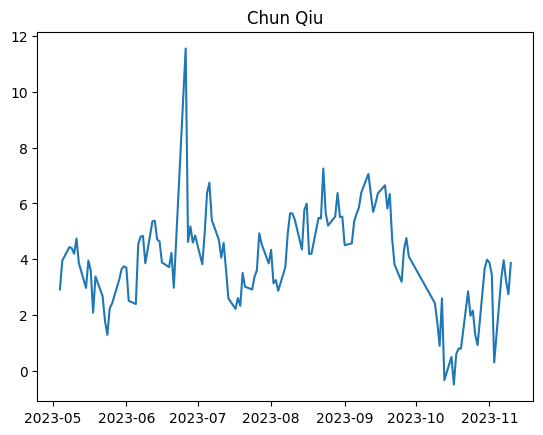

In [64]:
import matplotlib.pyplot as plt

high_code = 'sh113577'
low_code = 'sh113667'

dataset_high = dataset.bond_date(high_code, '', '')
dataset_low = dataset.bond_date(low_code, '', '')

dataset_high = dataset_high[dataset_high['date'] >= date(2023, 5, 1)]
dataset_low = dataset_low[dataset_low['date'] >= date(2023, 5, 1)]
dataset_total = pd.DataFrame({
    'date': dataset_high['date'].tolist(),
    'price_1': dataset_high['close'].tolist(),
    'price_2': dataset_low['close'].tolist()
})

dataset_total['diff'] = dataset_total['price_1'] - dataset_total['price_2']
plt.plot(dataset_total['date'], dataset_total['diff'])
plt.title('Chun Qiu')